In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from struct import unpack
from glob import glob
from datetime import datetime, timedelta

In [20]:
# DEFINE PHYSICAL CONSTANTS
PLANC = 6.62607015e-34  # Planck's constant in m2 kg / s
LIGHT = 2.99792458e8  # The speed of light in the vacuum in m / s
BOLTZ = 1.380649e-23  # Boltzmann's constant in m2 kg s-2 K-1

In [21]:
def load_bin(fpath: Path) -> bytes:
    """Load raw binary file as bytes.
    Args:
        fpath (Path): Path to the file
    Returns:
        bytes: Bytes of the file
    """
    with open(fpath, "rb") as f:
        fc = f.read()
    return fc


def unpack_header(byte_header: bytes) -> str:
    """Unpack 60byte (char) header.
    Args:
        byte_header (bytes): 60byte header
    Returns:
        str: Header
    """
    return b"".join(unpack("<60c", byte_header)).decode("latin_1")


def unpack_dims(bim_bytes: bytes):
    """Dim1 and Dim2 are 16-bit unsigned integers."""
    return unpack("<2H", bim_bytes)


def unpack_values(byte_values: bytes, num_pixels: int) -> np.ndarray:
    """Unpack the pixel values.
    - Size of each value is a 16-bit unsigned integer
    - Array (Dimension1 x Dimension2)
    Args:
        byte_file (bytes): Bytes of the file
        num_pixels (int): Number of pixels in the array
    Returns:
        np.ndarray: Array of values
    """
    values = unpack(f"<{num_pixels}H", byte_values)
    return np.array(list(values))


def reshape_values(values: np.ndarray, size: tuple):
    """Convert from 1D array (len = WxH) to 2D array (WxH).
    Args:
        values (np.ndarray): 1D array of values
        size (tuple): Size of the array (WxH)
    Returns:
        np.ndarray: 2D array of values
    """
    return np.reshape(values, size)


def plot_values(values: np.ndarray):
    """Plot the values."""
    plt.imshow(values)
    plt.tight_layout()
    plt.show()


def read_img_file(fpath: str | Path):
    """ Reads the binary .img files from a filepath and returns the .img file header and the image data
    Args:
        fpath (string): Location of the image file
    Returns:
        head (string): .img file 60 char header
        values (np.ndarray): 2D (512x512) array of image values
    """
    if isinstance(fpath, str):
        fpath = Path(fpath)
    if not fpath.exists():
        raise FileNotFoundError(f"File not found: {fpath}")

    bin = load_bin(fpath)
    head = unpack_header(bin[:60])  # First 60 bytes of the file is the header

    # Next 4 bytes are the dimensions (2x 16-bit unsigned integers)
    # Each integer is 2 bytes
    size = unpack_dims(bin[60:64])
    num_pixels = size[0] * size[1]  # WxH pixels in the array

    # The next num_pixels*2 bytes are the values
    values = unpack_values(bin[64 : 64 + num_pixels * 2], num_pixels=num_pixels)
    # Reshape into a 512x512 array (WxH)
    values = reshape_values(values, size)
    return head, values

In [22]:
def time_fname(fname):
    ''' Strips the time from a filename
    Args:
        fname (string) The filename of any typical OH Airglow Imager data file
        start (integer) Starting index of the time stamp
        end (integer) Final index of the time stamp
        timestring (string) The cut out timestamp string
    Returns
        Datetime object stripped from the timestamp'''
    
    start = fname.find('_')  # Time starts after the first _ character
    end = fname.find('.')  # Time ends just before the .img (or whatever)
    timestring = fname[start + 1:end]  # 1 index after the _ to the end

    return datetime.strptime(timestring, '%Y-%m-%d_%H-%M-%S')  # Time in format YYYY-MM-DD_HH-MM-SS

In [23]:
def get_image_pairs(channel5files, channel6files):
    '''Matches up the pairs of images by their time (stripped from filename using time_fname)
    Args:
        channel5files (list[strings]): The filenames of all the files in Channel 5 i.e. P1(2) filter
        channel6files (list[strings]): Ditto for Channel 6 i.e. P1(4) filter
    Returns:
        image_pairs (list[strings]): A sorted (in time) list of all the pairs of images i.e. images which are closer than 3 minutes apart'''
    
    image_pairs = []

    for fname5 in channel5files:  # For each file in channel 5
        for fname6 in channel6files:  # Then each file in channel 6
            time5 = time_fname(fname5)  # Get the time of each file
            time6 = time_fname(fname6)
            time_diff = abs(time6 - time5)  # Calculate the absolute time difference
            
            if time_diff < timedelta(minutes=3) or (time_diff.total_seconds() / 60) < 3:  # Check if less than 3 minutes
                image_pairs.append([fname5, fname6])  # If so, add to list of paired files

    return sorted(image_pairs)  # Return sorted list of paired files

In [24]:
def temperature_map(mapA, mapB):
    """
    This calculates the temperature of each pixel by comparing the intensity ratio of P1(2) / P1(4).

    :input mapA: (np.array) A calibrated intensity map of P1(2) emission (Channel 5)
    :input mapB:  (np.array) A calibrated intensity map of P1(4) emission (Channel 6)
    :list F: (list) Contains the rotational F(J`) terms for P1(2) and P1(4)
    :list J: (list) The rotational quantum numbers ditto
    :list A: (list) The Einstein coefficients (Loo et al., 2008) ditto
    :returns temp (np.array): A numpy array of the same size as mapA, mapB containing the rotational temperature of each pixel.
    """
    
    F = [-45.170339*100, 113.752553*100]  # The rotational terms see oh_einstein_temp_convert literature
    J = [1.5, 3.5]  # The rotational quantum numbers ""
    A = [0.434, 0.579]  # the Einstein coefficients Loo et al., 2008 ""
    
    temp = (((PLANC * LIGHT / BOLTZ) * (F[1] - F[0]))) / (np.log((mapA * A[1] * (2 * J[1] + 1)) / (mapB * A[0] * (2 * J[0] + 1))))
    
    return(temp)    

In [25]:
def cleanup_map(tempmap):
    ''' Clean up the look of the temperature map output by setting NaNs and non-physical temperatures to 0
    as well as the border region of the image.
    Args
        tempmap (np.array(512,512)) the temperature map
        imsize (int) the size of the img in pixels
    Returns
        clean (np.array(512,512)) the cleanup up map with zeros in place of noise/borders etc
        '''
    
    imsize = len(tempmap[:,0])  # Get the size in pix of the square = 512

    clean = np.nan_to_num(tempmap)  # Set any NaN values to zero
    #clean[np.where(clean >= 500)] = 0   # Set any non-physical pixels to zero, these are mostly stars or edge of image.

    for i in range(imsize):
        for j in range(imsize):
            if np.sqrt(((imsize/2) - i)**2 + ((imsize/2) - j)**2) >= 230:  # If the distance from the centre pixel is > 230 pix
                clean[i,j] = 0   # Sets edge pixels to zero.

    return clean

In [46]:
def projection(image):
    ''' Projects an all-sky map down onto a Svalbard map
    Based on UNIS-starcalibration/Matlab/test_map_airgow.m by Mikko Syr
    A lot of estimates right now, need to get better numbers
    After the constants get defined its all horrible MATLAB vector maths which I have just translated to Python as best as I can'''

    # Define constants used
    ALTIT = 87e3  # Altitude of the OH emission in m
    NGRID = 300  # Number of grid points along lat and lon
    MAXAN = 80  # Maximum angle from the zenith plotted (unkown)
    ZENIT = [512/2, 512/2]  # Location of zenith pixel (unknown so assumed centre of image)
    K = (512/2)/80  # Pixels per degree (unknown parameters used)
    NORTH = 0  # Direction to North (unknown)
    GLAT = 78.20  # Camera Latitude
    GLON = 15.70  # Camera Longitude
    REART = 6378.1e3  # Radius of Earth in m

    # Set up a grid in lat and lon
    lats = np.linspace(GLAT-2.6, GLAT+2.6, NGRID)
    lons = np.linspace(GLON-13, GLON+13, NGRID)

    theta0 = GLAT*np.pi/180  # The station latitude in rad
    phi0 = GLON*np.pi/180  # and longitude in rad

    r0 = REART * [np.cos(theta0)*np.cos(phi0), np.cos(theta0)*np.sin(phi0), np.sin(theta0)]  # The position vector to the station
    n0 = r0/np.gradient(r0)  # The normal vector at the station

    e_theta = [-np.sin(theta0)*np.cos(phi0), -np.sin(theta0)*np.sin(phi0), np.cos(theta0)]  # The unit vector in latitude
    e_phi = [-np.sin(phi0), np.cos(phi0), 0]  # The unit vector in longitude

    [thetamesh, phimesh] = np.meshgrid(lats*np.pi/180, lons*np.pi/180)  # Create a mesh of the local lats and lons

    theta = np.reshape(thetamesh, [], 1)  # Reshape into vectors for the following calcs
    phi = np.reshape(phimesh, [], 1)
    n_points = len(theta)

    r = (REART + ALTI) * [np.cos(theta) * np.cos(phi), np.cos(theta)*np.sin(phi), np.sin(theta)]  # Position vectors to grid points

    # Project the locations onto the plane (e_theta, e_phi) for azimuth calculations
    r0_tile = np.tile(r0, (1, n_points))
    e_theta_tile = np.tile(e_theta, (1, n_points))
    e_phi_tile = np.tile(e_phi, 1(1, n_points))
    n0_tile = np.tile(n0, (1, n_points))

    # Get plane coordinates using the dot product
    X = np.dot(r - r0_tile, e_theta_tile, 1)
    Y = np.dot(r - r0_tile, e_phi_tile, 1)
    azimuth = np.arctan2(X, Y)

    # Obtain the zenith angles for each point
    v = r - r0_tile
    ### v = bsxfun(@rdivide, v, sqrt(sum(v^2, 1)))  is the MATLAB code
    # bxsfun id for broadcasting, poss not needed in numpy?
    # @rdivide I assume is real divide? 
    v = v / sqrt(sum(v^2, 1))  # This might have problems, is it element wise? Turns each column into a unit vector (ideally)

    # Zenith angles between unit vectors and plane normal
    z = np.arccos(np.dot(v, n0_tile))

    # Ignore pixels with too large a zenith angle
    z[np.where(z > MAXAN*np.pi/180)] = np.nan

    # Get the corresponding pixels from the allsky image
    d = K * z * 180/np.pi
    i = ZENIT[0] - d * np.sin(azimuth - NORTH)
    j = ZENIT[1] - d * np.cos(azimuth - NORTH)

    # Interpolate intensities from the image
    # - Convert the vector to image matrix
    # - Out of matrix values will be NaN
    # - Reorient to match the lat, lon grid

    mapped = np.reshape()

    return 

In [ ]:
import math

def project_airglow_to_latlon(image, airglow_altitude, max_angle, zenith_location, pixels_per_degree, north_direction, camera_lat, camera_lon, earth_radius):
    # Calculate the image dimensions
    image_height, image_width = image.shape[:2]

    # Convert camera latitude and longitude to radians
    camera_lat_rad = math.radians(camera_lat)
    camera_lon_rad = math.radians(camera_lon)

    # Calculate the zenith angle in radians
    zenith_angle_rad = math.radians(max_angle)

    # Calculate the altitude of the airglow in meters
    airglow_altitude_m = airglow_altitude * 1000

    # Calculate the zenith coordinates
    zenith_x, zenith_y = zenith_location

    # Calculate the angular size of each pixel in degrees
    pixel_angle = 1 / pixels_per_degree

    # Initialize the output array for latitude and longitude values
    latitudes = []
    longitudes = []

    # Iterate through each pixel in the image
    for y in range(image_height):
        for x in range(image_width):
            # Calculate the angle from the zenith for the current pixel
            angle_x = (x - zenith_x) * pixel_angle
            angle_y = (y - zenith_y) * pixel_angle

            # Calculate the distance from the camera to the airglow point
            distance = earth_radius + airglow_altitude_m

            # Calculate the latitude and longitude offsets
            latitude_offset = math.sin(zenith_angle_rad + angle_y) * distance / earth_radius
            longitude_offset = math.sin(angle_x) * distance / earth_radius

            # Calculate the latitude and longitude of the airglow point
            latitude = math.degrees(math.asin(math.sin(camera_lat_rad) * math.cos(latitude_offset) + 
                                              math.cos(camera_lat_rad) * math.sin(latitude_offset) * 
                                              math.cos(north_direction + longitude_offset))))
            longitude = math.degrees(camera_lon_rad + math.atan2(math.sin(north_direction + longitude_offset) * 
                                                                 math.sin(latitude_offset) * math.cos(camera_lat_rad), 
                                                                 math.cos(latitude_offset) - math.sin(camera_lat_rad) * 
                                                                 math.sin(math.radians(latitude))))

            # Append the latitude and longitude to the output arrays
            latitudes.append(latitude)
            longitudes.append(longitude)

    return latitudes, longitudes


In [1]:
def calibrated(image):
    ''' Return the image with calibration
    - Remove the corner dark values 
    Args:
        Image : np.array (512, 512)
    Returns:
        Calibrated (np.array(512, 512)): Image with the average corner dark removed'''
    return image - corner_dark(image)

In [28]:
def corner_dark(image):
    ''' Returns the average dark current from the corners of the images
    Args:
        Image: np.array(512, 512)
    Returns:
        Float: The average dark current'''
    
    imsize = 512
    corner = []  # List of all the values from the image corners

    for i in range(imsize):
        for j in range(imsize):
            if np.sqrt(((imsize/2) - i)**2 + ((imsize/2) - j)**2) >= 240:  # If distance from centre of image is over 240 pixels (just leaving corners)
                corner.append(image[i,j])  # Save the value of the corner pixel value

    return sum(corner)/len(corner)  # Return the mean of the corner

In [29]:
def get_keogram(folder5, folder6, no):
    ''' Creates a temperature map keogram
    Args:
        folder5 (string): Filepath to folder where Channel 5 P1(2) images are
        folder6 (string): Filepath for Channel 6 P1(4) images
        no (int): Number of files to include in the keogram
    Returns:
        timestamps (list[datetime objects]): List of timestamps for each keo slice
        keogram (np.array(512, 512)): Keogram data in 2D array'''
    
    tempmaps = get_tempmaps(folder5, folder6, no)  # Get all the temperature maps

    timestamps = [] 
    [timestamps.append(time_fname(file)) for file in folder5]  # And get the timestamps for each file

    keos = []
    for map in tempmaps:
        slit = map[int((512/2) - 10):int((512/2) + 10), :]
        slit_av = sum(slit, 1)/20
        keos.append(slit_av)

    keogram = np.array(keos).T
    
    return timestamps, keogram


In [30]:
def get_tempmaps(folder5, folder6, no):
    ''' Retrieves the temperature maps for every image pair in give folders
    Args:
        folder5 (string): Filepath to folder where Channel 5 P1(2) images are
        folder6 (string): Filepath for Channel 6 P1(4) images
        no (int): Number of files to include
    Returns:
        tempmaps (list(nd.array(512, 512))): List of temperature map 2D array data'''

    image_pairs = get_image_pairs(folder5, folder6)  # Get each pair of images

    tempmaps = []
    for images in image_pairs[0:no]:
        header, mapA = read_img_file(images[0])
        header, mapB = read_img_file(images[1])
        
        temp_map = temperature_map(calibrated(mapA), calibrated(mapB))
        tempmaps.append(temp_map)

    return tempmaps
    

In [35]:
timestamps, keogram = get_keogram(ch5fs, ch6fs, 100)

/tmp/ipykernel_7197/2723060790.py:17: RuntimeWarning: invalid value encountered in log
  temp = (((PLANC * LIGHT / BOLTZ) * (F[1] - F[0]))) / (np.log((mapA * A[1] * (2 * J[1] + 1)) / (mapB * A[0] * (2 * J[0] + 1))))


In [36]:
np.shape(keogram)

(512, 100)

(-0.5, 124.0, 511.5, -0.5)

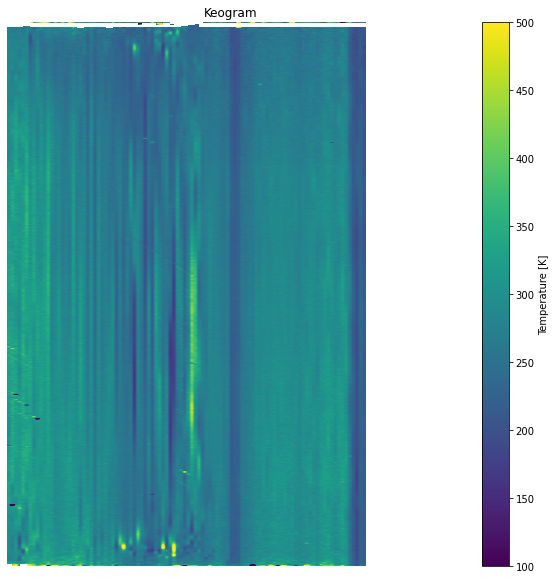

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(keogram, vmin=100, vmax = 500, aspect='auto')
plt.yticks([])
plt.xticks(range(125), timestamps)
plt.colorbar(label='Temperature [K]')
plt.title('Keogram')
plt.axis('off')

In [34]:
ch5fs = glob('27/CH5/*.img')
ch6fs = glob('27/CH6/*.img')

In [38]:
image_pairs = get_image_pairs(ch5fs, ch6fs)

for i in range(15):
    print(image_pairs[i])

['27/CH5/W8465B18_2022-11-27_00-02-00.img', '27/CH6/W8400B18_2022-11-27_00-04-03.img']
['27/CH5/W8465B18_2022-11-27_00-10-44.img', '27/CH6/W8400B18_2022-11-27_00-12-46.img']
['27/CH5/W8465B18_2022-11-27_00-19-27.img', '27/CH6/W8400B18_2022-11-27_00-21-30.img']
['27/CH5/W8465B18_2022-11-27_00-28-11.img', '27/CH6/W8400B18_2022-11-27_00-30-13.img']
['27/CH5/W8465B18_2022-11-27_00-37-27.img', '27/CH6/W8400B18_2022-11-27_00-39-29.img']
['27/CH5/W8465B18_2022-11-27_00-46-10.img', '27/CH6/W8400B18_2022-11-27_00-48-13.img']
['27/CH5/W8465B18_2022-11-27_00-54-53.img', '27/CH6/W8400B18_2022-11-27_00-56-56.img']
['27/CH5/W8465B18_2022-11-27_01-03-37.img', '27/CH6/W8400B18_2022-11-27_01-05-39.img']
['27/CH5/W8465B18_2022-11-27_01-12-20.img', '27/CH6/W8400B18_2022-11-27_01-14-23.img']
['27/CH5/W8465B18_2022-11-27_01-21-04.img', '27/CH6/W8400B18_2022-11-27_01-23-06.img']
['27/CH5/W8465B18_2022-11-27_01-29-47.img', '27/CH6/W8400B18_2022-11-27_01-31-50.img']
['27/CH5/W8465B18_2022-11-27_01-38-31.img',

In [39]:
header, mapA = read_img_file(image_pairs[80][0])
header, mapB = read_img_file(image_pairs[80][1])

In [40]:
ch5map = calibrated(mapA)
ch6map = calibrated(mapB)

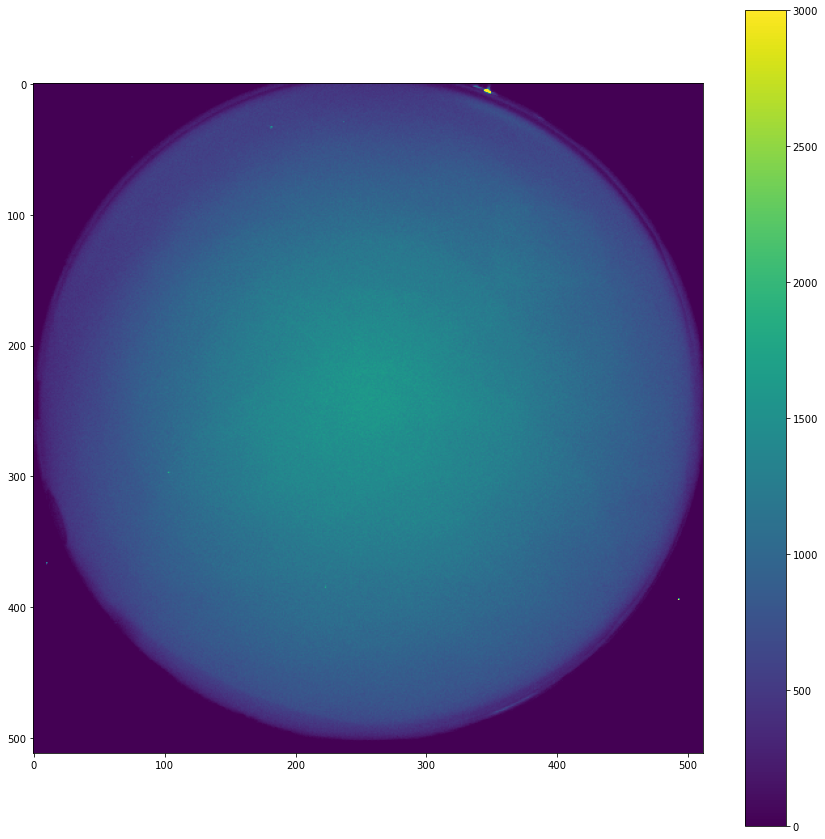

In [41]:
plt.figure(figsize=(15, 15))
plt.imshow(mapB - corner_dark(mapB), vmin=0, vmax=3000)
plt.colorbar()
plt.savefig('Starmap.png')

In [42]:
tempmap = temperature_map(ch5map, ch6map)
cleaned = cleanup_map(tempmap)

/tmp/ipykernel_7197/2723060790.py:17: RuntimeWarning: invalid value encountered in log
  temp = (((PLANC * LIGHT / BOLTZ) * (F[1] - F[0]))) / (np.log((mapA * A[1] * (2 * J[1] + 1)) / (mapB * A[0] * (2 * J[0] + 1))))


In [43]:
temp_mean = tempmap[int((512/2) - 5):int((512/2) + 5), int((512/2) - 5):int((512/2) + 5)]  # Central 100 pixels
temp_mean = np.sum(temp_mean)/100
print(temp_mean)


282.7509152917329


(-0.5, 511.5, 511.5, -0.5)

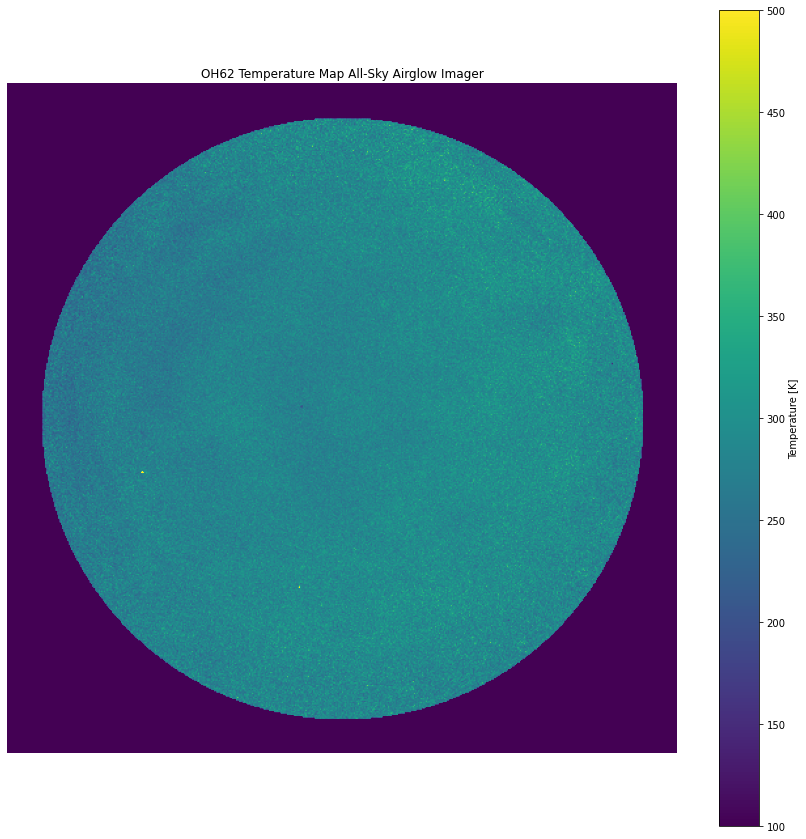

In [44]:
plt.figure(figsize=(15, 15))
plt.imshow(cleaned, vmin=100, vmax = 500)
plt.colorbar(label='Temperature [K]')
plt.title('OH62 Temperature Map All-Sky Airglow Imager')
plt.axis('off')